In [21]:
!nvidia-smi

Fri May  3 22:10:36 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:17:00.0 Off |                    0 |
| N/A   28C    P0    34W / 250W |   2293MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Installing necessary packages

In [2]:
!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]
!pip install stable_baselines3

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.


In [3]:
!pip install utils

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.


# importing all necessary libraries

In [4]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torch.distributions import Categorical
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time
import uuid
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

from stable_baselines3.common.atari_wrappers import ClipRewardEnv, FireResetEnv, MaxAndSkipEnv, NoopResetEnv

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/tensorflow/2.11.0-CUDA-11.8.0/lib/python3.9/site-packages/tensorboard/compat/proto/histogram_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/tensorflow/2.11.0-CUDA-11.8.0/lib/python3.9/site-packages/tensorboard/compat/proto/histogram_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1

# Defining parameters

In [5]:
ENV_ARGS = {
    'id': "PongDeterministic-v4"
}
NUM_ENVS = 3  # Pong is typically trained with a single environment
SEED = 1
LR = 1e-4
NUM_STEPS = 2048
NUM_ITERATIONS = 1000
GAMMA = 0.99
GAE_LAMBDA = 0.95
UPDATE_EPOCHS = 10
CLIP_COEF = 0.2
ENTROPY_COEF = 0.0
VF_COEF = 0.5
MAX_GRAD_NORM = 0.5
MINI_BATCH_COUNT = 64
UPDATE_PLOTS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = ', DEVICE)

# Output directory
ROOT = os.getcwd()
OUTPUT = os.path.join(ROOT, 'output')

if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)
# Seeding
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


device =  cuda


In [6]:
gym.envs.registration.registry.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'GymV26Environment-v0', 'GymV21Environment-v0', 'Adventure-v0', 'AdventureDeterministic-v0', 'AdventureNoFrameskip-v0

# Defining functions

In [1]:
def make_env(**env_args):
    env = gym.make(**env_args)
    # env = gym.wrappers.FlattenObservation(env)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip = 4)

    env = ClipRewardEnv(env)
    env = gym.wrappers.ResizeObservation(env, (84,84))
    env = gym.wrappers.GrayScaleObservation(env)
    env = gym.wrappers.FrameStack(env, 4)
    return env

In [8]:
# Test env
envs = gym.vector.SyncVectorEnv(
    [lambda : make_env(**ENV_ARGS) for _ in range(NUM_ENVS)]
)

assert isinstance(envs.single_action_space, gym.spaces.Discrete), 'Only discrete action is supported'

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [9]:
def layer_init(layer: nn.Linear, std = np.sqrt(2), bias_const = 0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class Agent(nn.Module):

    def __init__(self, envs: gym.Env, hidden_size: int = 512):

        super().__init__()

        self.network = nn.Sequential(
            layer_init(nn.Conv2d(4, 32, 8, stride = 4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 4, stride = 2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride = 1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 7 * 7, hidden_size)),
            nn.ReLU(),
        )

        self.actor = layer_init(nn.Linear(hidden_size, envs.single_action_space.n), std = 0.01)
        self.critic = layer_init(nn.Linear(hidden_size,1 ), std = 1.0)

    def get_value(self, x):
        return self.critic(self.network(x/255.0))

    def get_action_and_value(self, x, action = None):
        '''
        @params:
            x: torch.tensor observation, shape = (N, observation size)
            action: torch.tensor action
        @returns:
            action: torch.tensor, shape = (N, action size)
            log_prob: torch.tensor, shape = (N,)
            entropy: torch.tensor, shape = (N,)
            value: torch.tensor, shape = (N,)
        '''

        hidden = self.network(x/255.0)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action == None:
            action = probs.sample()

        log_prob = probs.log_prob(action)
        entropy = probs.entropy()
        value = self.critic(hidden)
        return action, log_prob, entropy, value


In [10]:
#Test agent
# Test env
envs = gym.vector.SyncVectorEnv(
    [lambda : make_env(**ENV_ARGS) for _ in range(NUM_ENVS)]
)

assert isinstance(envs.single_action_space, gym.spaces.Discrete), 'Only discrete action is supported'

obs, info = envs.reset()
obs = torch.tensor(obs).float()
print('obs shape = ', obs.shape)

test_agent = Agent(envs)

action, log_prob, entropy, value = test_agent.get_action_and_value(obs)

print('action shape = ', action.shape)
print('log prob shape = ', log_prob.shape)
print('entropy shape = ', entropy.shape)
print('value shape = ', value.shape)

envs.close()
del test_agent


obs shape =  torch.Size([3, 4, 84, 84])
action shape =  torch.Size([3])
log prob shape =  torch.Size([3])
entropy shape =  torch.Size([3])
value shape =  torch.Size([3, 1])


In [11]:
def plot(history, show = False, save_path = None):
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))))

    if save_path != None:
        plt.savefig(save_path)
    if show:
        plt.show()

    plt.clf()
    plt.close()

In [12]:
def evaluate(agent, episodes = 10):
    envs = gym.vector.SyncVectorEnv([lambda: make_env(gamma = GAMMA, **ENV_ARGS)])
    agent.eval()
    total_rewards = []
    next_obs, _ = envs.reset()

    while len(total_rewards) < episodes:
        next_obs = torch.Tensor(next_obs)
        with torch.no_grad():
            action, log_prob, _, value = agent.get_action_and_value(next_obs)

        next_obs, reward, terminated, truncated, info = envs.step(action.numpy())

        if 'final_info' in info:
            for data in info['final_info']:
                if data:
                    reward = data['episode']['r'][0]
                    total_rewards.append(reward)

    return total_rewards

In [30]:
#print('Saving model to:', SAVE_PATH)

# Training loop

In [13]:
# Create env
envs = gym.vector.AsyncVectorEnv(
    [lambda: make_env(**ENV_ARGS) for _ in range(NUM_ENVS)]
)

agent = Agent(envs).to(DEVICE)
optimizer = torch.optim.AdamW(agent.parameters(), lr=LR, eps=1e-5, amsgrad=True)

M = NUM_STEPS
N = NUM_ENVS

label = str(uuid.uuid4()).split('-')[0]
print('run id = ', label)

SAVE_PATH = os.path.join(OUTPUT, label)
FIG_SAVE_PATH = os.path.join(SAVE_PATH, 'plot_inst5.png')
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

obs = torch.zeros((M, N) + envs.single_observation_space.shape, device=DEVICE)
actions = torch.zeros((M, N) + envs.single_action_space.shape, device=DEVICE)
log_probs = torch.zeros((M, N), device=DEVICE)
rewards = torch.zeros((M, N), device=DEVICE)
dones = torch.zeros((M, N), device=DEVICE)  # for masking
values = torch.zeros((M, N), device=DEVICE)

global_step = 0

next_obs, _ = envs.reset()
next_obs = torch.tensor(next_obs, device=DEVICE)
next_done = torch.zeros(N, device=DEVICE)  # N is num envs

print('next obs = ', next_obs.shape)
print('next done = ', next_done.shape)

reward_window = deque(maxlen=100)
history = defaultdict(list)

loop = tqdm(range(NUM_ITERATIONS))
agent.train()

best_score = float('-inf')
evaluation = 0
loss = float('inf')

for iter in loop:
    if iter % UPDATE_PLOTS == 0:
        plot(history, save_path=FIG_SAVE_PATH)

    for step in range(M):
        global_step += N

        obs[step] = next_obs
        dones[step] = next_done

        with torch.no_grad():
            action, log_prob, _, value = agent.get_action_and_value(next_obs)
            values[step] = value.flatten()

        actions[step] = action
        log_probs[step] = log_prob

        next_obs, reward, terminated, truncated, info = envs.step(action.cpu().numpy())
        next_done = torch.logical_or(torch.tensor(terminated), torch.tensor(truncated)).to(DEVICE)

        rewards[step] = torch.tensor(reward, device=DEVICE).view(-1)
        next_obs = torch.tensor(next_obs, device=DEVICE)

        if 'final_info' in info:
            for data in info['final_info']:
                if data:
                    reward = data['episode']['r']
                    reward_window.append(reward)
                    avg_reward = torch.tensor(list(reward_window)).mean().item()
                    history['reward'].append(avg_reward)
                    loop.set_description(f"Reward = {avg_reward:.2f}, Global Step = {global_step}, Best Score = {best_score:.2f}, Loss = {loss:.2f}, Steps = {step}")

                    if best_score < avg_reward:
                        best_score = avg_reward
                        torch.save(agent.state_dict(), os.path.join(SAVE_PATH, 'ppo.checkpoint_inst5.torch'))

# Continue with optimization phase
        # OPTIMIZE phase:
    with torch.no_grad():
        # Bootstrap values, compute returns
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards, device=DEVICE)
        last_gae_lam = 0

        for t in reversed(range(M)):
            if t == M - 1:
                next_non_terminal = 1.0 - next_done.float()
                next_values = next_value
            else:
                next_non_terminal = 1.0 - dones[t + 1].float()
                next_values = values[t + 1]

            # GAE-Lambda advantage calculation
            delta = rewards[t] + GAMMA * next_values * next_non_terminal - values[t]
            advantages[t] = last_gae_lam = delta + GAMMA * GAE_LAMBDA * next_non_terminal * last_gae_lam

            # Compute returns by adding values to advantages
        returns = advantages + values

    # Flatten the tensors to prepare for mini-batch gradient descent
    b_obs = obs.view((-1,) + envs.single_observation_space.shape)
    b_actions = actions.view((-1,) + envs.single_action_space.shape)
    b_log_probs = log_probs.view(-1)
    b_advantages = advantages.view(-1)
    b_returns = returns.view(-1)
    b_values = values.view(-1)

    # Batch indices preparation for mini-batch updates
    batch_size = M * N
    mini_batch_size = batch_size // MINI_BATCH_COUNT
    b_indices = torch.arange(batch_size, device=DEVICE)
    clip_fracs = []

    for epoch in range(UPDATE_EPOCHS):
        # Shuffle batch indices to decorrelate the batches
        b_indices = b_indices[torch.randperm(batch_size)]

        for start in range(0, batch_size, mini_batch_size):
            end = start + mini_batch_size
            mini_indices = b_indices[start:end]

            _, new_log_prob, entropy, new_value = agent.get_action_and_value(b_obs[mini_indices], b_actions[mini_indices])

            # Policy gradient loss calculation
            log_ratio = new_log_prob - b_log_probs[mini_indices]
            ratio = torch.exp(log_ratio)

            # Calculate surrogate losses - there is with torch.no_grad() missing here to approximate KL
            surr1 = ratio * b_advantages[mini_indices]
            surr2 = torch.clamp(ratio, 1.0 - CLIP_COEF, 1.0 + CLIP_COEF) * b_advantages[mini_indices]
            policy_loss = -torch.min(surr1, surr2).mean()

            # Value loss using mean squared error
            value_loss = 0.5 * (new_value.view(-1) - b_returns[mini_indices]).pow(2).mean()

            # Total loss
            loss = policy_loss + VF_COEF * value_loss - ENTROPY_COEF * entropy.mean()

            # Perform gradient descent step
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), MAX_GRAD_NORM)
            optimizer.step()

            # Optional: collect information about clipping
            clip_frac = ((ratio - 1.0).abs() > CLIP_COEF).float().mean().item()
            clip_fracs.append(clip_frac)

# Final evaluation and model saving after training
#evaluation = evaluate(agent)  # Assuming evaluate function returns a scalar or a tensor
#print('Final evaluation score:', evaluation)
torch.save(agent.state_dict(), os.path.join(SAVE_PATH, 'ppo.final_corrected_inst5.torch'))


run id =  f07be2b0
next obs =  torch.Size([3, 4, 84, 84])
next done =  torch.Size([3])


Reward = 18.82, Global Step = 6143610, Best Score = 20.73, Loss = 0.02, Steps = 1917: 100%|██████████| 1000/1000 [8:59:06<00:00, 32.35s/it]  


# Evaluation

In [16]:
import torch
NUM_ENVS = 1
def evaluate(agent, episodes=10):
    # Create a synchronous vector environment
    envs = gym.vector.SyncVectorEnv([lambda: make_env(**ENV_ARGS) for _ in range(NUM_ENVS)])

    # Put the agent into evaluation mode
    agent.eval()

    total_rewards = []
    episode_rewards = [0.0] * NUM_ENVS  # Initialize rewards for each environment
    episode_counts = [0] * NUM_ENVS    # Track the number of episodes completed per environment

    # Reset environments
    obs, _ = envs.reset()
    obs = torch.tensor(obs, dtype=torch.float32).to(DEVICE)  # Convert observations to tensors

    while min(episode_counts) < episodes:
        with torch.no_grad():
            action, _, _, _ = agent.get_action_and_value(obs)
            action = action.cpu().numpy()  # Convert actions to numpy array for the environment

        next_obs, rewards, terminated, truncated, infos = envs.step(action)

        # Update episode rewards and counts
        for i in range(NUM_ENVS):
            episode_rewards[i] += rewards[i]
            if terminated[i] or truncated[i]:
                total_rewards.append(episode_rewards[i])
                print(f"Environment {i+1}, Episode {episode_counts[i]+1}/{episodes}: Reward = {episode_rewards[i]:.2f}")
                episode_rewards[i] = 0  # Reset the reward counter for the next episode
                episode_counts[i] += 1  # Increment the episode count for this environment
                
        # Prepare next observations
        obs = torch.tensor(next_obs, dtype=torch.float32).to(DEVICE)

        # If enough episodes have been completed, break early
        if min(episode_counts) >= episodes:
            break

    envs.close()  # Always make sure to close environments
    return total_rewards

# Example usage:
#test_agent = Agent(NUM_ENVS, envs.single_action_space.n).to(DEVICE)  # Make sure the agent is properly initialized
test_agent = agent
average_reward = np.mean(evaluate(test_agent, episodes=10))
print("Evaluation Average Reward:", average_reward)


Environment 1, Episode 1/10: Reward = 21.00
Environment 1, Episode 2/10: Reward = 21.00
Environment 1, Episode 3/10: Reward = -21.00
Environment 1, Episode 4/10: Reward = 21.00
Environment 1, Episode 5/10: Reward = 21.00
Environment 1, Episode 6/10: Reward = 21.00
Environment 1, Episode 7/10: Reward = 21.00
Environment 1, Episode 8/10: Reward = 21.00
Environment 1, Episode 9/10: Reward = 21.00
Environment 1, Episode 10/10: Reward = 21.00
Evaluation Average Reward: 16.8


Environment 1, Episode 1/10: Reward = 21.00
Environment 1, Episode 2/10: Reward = 20.00
Environment 1, Episode 3/10: Reward = 21.00
Environment 1, Episode 4/10: Reward = 21.00
Environment 1, Episode 5/10: Reward = 21.00
Environment 1, Episode 6/10: Reward = 21.00
Environment 1, Episode 7/10: Reward = 20.00
Environment 1, Episode 8/10: Reward = 21.00
Environment 1, Episode 9/10: Reward = 19.00
Environment 1, Episode 10/10: Reward = 21.00


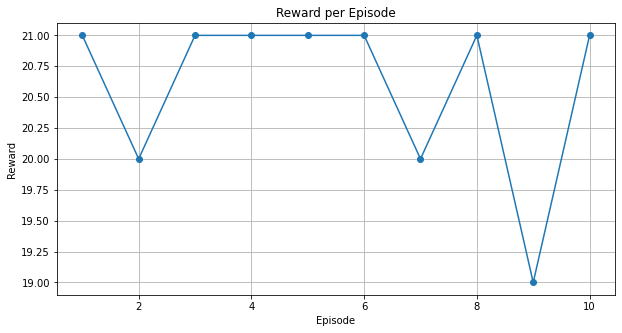

Evaluation Average Reward: 20.6


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'evaluate' function is already defined and working correctly
rewards_test = evaluate(test_agent, episodes=10)

# Plotting the rewards per episode
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), rewards_test, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward per Episode")
plt.grid(True)

# Show the plot
plt.show()

# Calculate and print the average reward
average_reward = np.mean(rewards_test)
print("Evaluation Average Reward:", average_reward)


# Best evaluation - selected

Environment 1, Episode 1/10: Reward = 21.00
Environment 1, Episode 2/10: Reward = 21.00
Environment 1, Episode 3/10: Reward = 21.00
Environment 1, Episode 4/10: Reward = 21.00
Environment 1, Episode 5/10: Reward = 21.00
Environment 1, Episode 6/10: Reward = 21.00
Environment 1, Episode 7/10: Reward = 21.00
Environment 1, Episode 8/10: Reward = 21.00
Environment 1, Episode 9/10: Reward = 20.00
Environment 1, Episode 10/10: Reward = 20.00


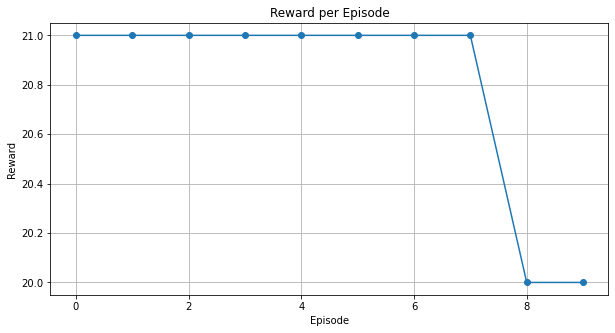

Evaluation Average Reward: 20.8


In [18]:
rewards_test = evaluate(test_agent, episodes=10)

# Plotting the rewards per episode
plt.figure(figsize=(10, 5))
plt.plot(rewards_test, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward per Episode")
plt.grid(True)

# Show the plot
plt.show()

# Calculate and print the average reward
average_reward = np.mean(rewards_test)
print("Evaluation Average Reward:", average_reward)

# plotting training curve

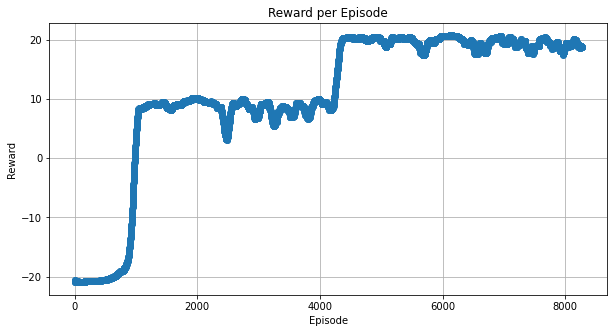

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(history['reward'], marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward per Episode")
plt.grid(True)

# Show the plot
plt.show()

# plotting average reward window

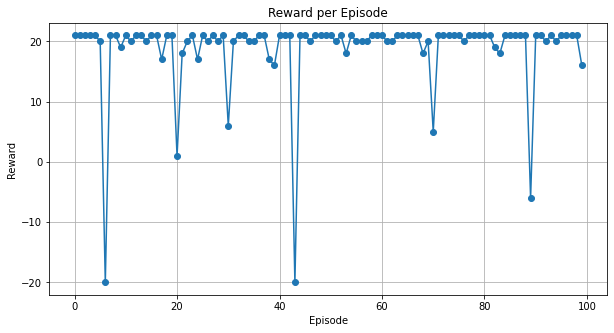

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(reward_window, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward per Episode")
plt.grid(True)

# Show the plot
plt.show()